In [1]:
from utils.functions import *

import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv('../data/clini_data.csv')

In [2]:
# On vérifie qu'on n'a pas de doublons
data['NCTId'].nunique() == len(data)

True

## I Présentation des données

Notre dataframe possède plus de 300 variables. On ne les utiliseras pas toutes, on présente alors les principales variables qu'on utilisera

In [3]:
afficher_colonnes_manquantes(data, seuil=0.99)

╒═════════════════════════════════════════╤════════════════════════════════╤═════════════════════════════════════╕
│ Colonne                                 │   Nombre de valeurs manquantes │   Pourcentage de valeurs manquantes │
╞═════════════════════════════════════════╪════════════════════════════════╪═════════════════════════════════════╡
│ AgreementOtherDetails                   │                          99849 │                              99.849 │
├─────────────────────────────────────────┼────────────────────────────────┼─────────────────────────────────────┤
│ AgreementPISponsorEmployee              │                          99358 │                              99.358 │
├─────────────────────────────────────────┼────────────────────────────────┼─────────────────────────────────────┤
│ AgreementRestrictionType                │                          99791 │                              99.791 │
├─────────────────────────────────────────┼────────────────────────────────┼────

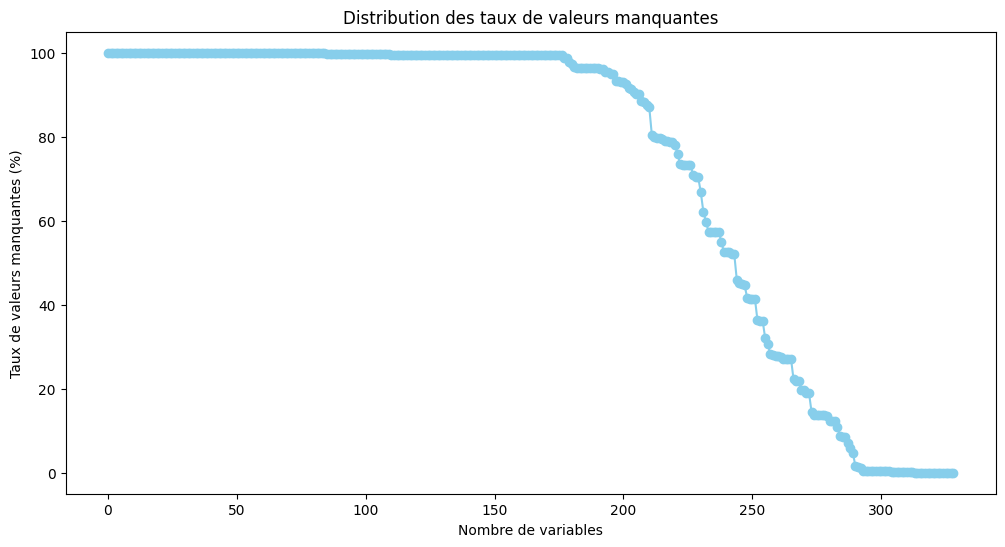

In [4]:
plot_distribution_valeurs_manquantes(data)

Environ la moitié des variables possèdent plus de ``99%`` de valeurs manquantes

In [5]:
data.sample(10)[['NCTId','BriefTitle','StartDate', 'LocationCountry', 'StudyType', 'Phase','EligibilityCriteria',"LeadSponsorClass"]]

,NCTId,BriefTitle,StartDate,LocationCountry,StudyType,Phase,EligibilityCriteria,LeadSponsorClass
65406,NCT05329753,Effectiveness of a Mobile Health Intervention ...,"September 15, 2019",Spain,Interventional,Not Applicable,Inclusion Criteria:\n\nAdolescents who were st...,OTHER
15366,NCT05980858,Effects of Exogenous Ketosis on Renal Function...,August 2023,NaN,Interventional,Not Applicable,Inclusion Criteria:\n\nBMI < 30 kg/m2\nSafe co...,OTHER
53067,NCT05490394,Correlation Study of PAI-1 4G/5G Polymorphism ...,August 2022,NaN,Observational,NaN,Inclusion Criteria:\n\n- 1) Stanford type A ao...,OTHER
7708,NCT06080438,Effect of Topical Botulinum Toxin Eyedrop on P...,"November 29, 2022",United States,Interventional,Phase 4,Inclusion Criteria:\n\nAdults aged 18 and abov...,OTHER
69389,NCT05277922,Effect of C21 on Forearm Blood Flow,"April 28, 2022",Sweden,Interventional,Phase 1,Inclusion Criteria:\n\nWilling and able to giv...,INDUSTRY
87508,NCT05042154,Prevalence of OSA in COPD and the Clinical Imp...,"October 31, 2021",NaN,Interventional,Not Applicable,Inclusion Criteria: Inclusion criteria include...,OTHER
87002,NCT05048732,Imaging Apoptosis for Lymphoma Treatment Response,"December 6, 2021",United States,Interventional,Early Phase 1,Inclusion Criteria (Healthy Volunteers):\n\nAd...,OTHER
54703,NCT05469100,A Study of Effect of Selpercatinib (LY3527723)...,"December 19, 2018",United States,Interventional,Phase 1,Inclusion Criteria:\n\nFor all participants:\n...,INDUSTRY
85668,NCT05066113,Feasibility Study on Radiofrequency-Based Sele...,"August 15, 2017",United States,Interventional,Not Applicable,Inclusion Criteria:\n\nFor primary objective: ...,OTHER
67641,NCT05300659,A STudy of Upper Arm Rehabilitation in Stroke ...,"April 4, 2022",United Kingdom,Interventional,Not Applicable,Inclusion Criteria:\n\nStroke Survivors admitt...,OTHER


#### NCTId

Le ``NCTId`` d'un essai clinique est l'identifiant NCT d'un essai clinique. Chaque essai clinique a un identifiant unique.

In [6]:
data['NCTId'].nunique() == len(data)

True

Si il y a eu un problème lors de la récolte des données, on peut supprimer les doublons à l'aide du NCTId

#### Dates de l'essais cliniques

In [7]:
data['StartDateType'].unique()

array(['Actual', 'Anticipated', nan], dtype=object)

Etant donné qu'on cherche à expliquer la durée d'un essai clinique, on s'intéresse particulièrement aux variables précisant les dates de l'essai clinique. La variable ``StartDate`` indique la date de début de l'essai clinique. La variable ``StartDateType`` indique si la date précisée est factuelle ou prévu. Pour simplifier notre analyse, on traitera les dates de la même manière (si elles sont anticipées ou non)

In [8]:
data[['StartDate','StartDateType']].sample(10)

,StartDate,StartDateType
32057,"August 31, 2024",Anticipated
654,"December 5, 2023",Actual
161,"May 10, 2020",Actual
28342,"August 1, 2023",Anticipated
2119,"April 15, 2023",Actual
55873,"July 1, 2024",Anticipated
19270,"September 12, 2020",Actual
95539,"May 20, 2021",Actual
40826,"October 20, 2022",Actual
68841,"April 1, 2022",Anticipated


Les variables de dates sont sous forme de ``[str]`` et on doit donc les convertir en format datetime afin de pouvoir faire des opérations dessus. On appliquera cette transformation pour toute les variables relatives à la date qu'on utilisera.

In [9]:
type(data['StartDate'].iloc[20])

str

In [10]:
data['StartDate'] = pd.to_datetime(data['StartDate'], format='%B %d, %Y', errors='coerce')

In [11]:
type(data['StartDate'].iloc[20])

pandas._libs.tslibs.timestamps.Timestamp

La variable ``CompletionDate`` indique la date de fin (anticipée ou factuelle) d'un essai clinique. On différentie cette variable et ``StartDate`` pour avoir la durée d'un essai clinique et on crée la variable ``TimePassed``

In [22]:
df = data_treatment(data)

In [23]:
df['TimePassed'].head(5)

0    745.0
1    303.0
2    275.0
3    336.0
4    116.0
Name: TimePassed, dtype: float64

On applique une sélection de données. En effet certaines variables n'ont pas été renseignées correctement. Un certain nombre d'essai clinique on la même date pour ``StartDate`` et ``CompletionDate``. Or un essai clinique ne peut se réaliser en un seul jour, on suppose donc que cela est simplement du à une mauvaise compréhension de la variable lors de sa saisie. On ne prends pas en compte les essais cliniques ayant une durée trop élevé car ils relèvent généralement de cas particulier et peuvent être considérés comme des outliers.

#### Critères d'éligibilités

On utilise aussi les critères d'éligibilité car on veut voir si ils ont un impact sur la durée de vie d'un essai clinique. Les données présentent certains critères qui sont <u>standardisées</u> et d'autres non. Par exemple certains critères comme l'age et le sexe des patients demandées sont présents dans une variable précise comme ``MaximumAge`` tandis que d'autres critères, généralement plus complexes et divers sont présent dans la variable ``EligibilityCriteria`` sous forme de texte.

In [24]:
data[['MinimumAge','MaximumAge','Gender']].sample(10)

,MinimumAge,MaximumAge,Gender
46419,18 Years,NaN,All
46798,18 Years,NaN,All
76567,20 Years,50 Years,All
82739,18 Years,65 Years,All
59443,18 Years,90 Years,All
49484,18 Years,41 Years,Female
79802,18 Years,75 Years,All
74619,18 Years,NaN,All
76553,18 Years,75 Years,All
40019,16 Years,50 Years,All


In [25]:
print(data['EligibilityCriteria'].iloc[10])

Inclusion Criteria:

diagnosed with T2DM
any sex/gender
any race/ethnicity
any socioeconomic group
has a smartphone
receives care in a Federally Qualified Healthcare Center in Southern Arizona

Exclusion Criteria:

Individuals with T1DM
Individuals with gestational DM
Individuals with pre-diabetes
children
pregnant women
Individuals unable to provide informed consent
Individuals with other serious co-occurring health condition (e.g., active cancer treatment)


La variable ``EligibilityCriteria`` fera l'objet d'un traitement particulier. Afin de pouvoir comparer différents essais cliniques, on appliquera un modèle de NLP pour repérer les mots importants (par exemple les maladies, les procédures etc...) et ainsi obtenir le nombre de critères relatif à un domaine.

#### Variables Géographiques

On possède aussi le pays d'origine d'un essai clinique ainsi que le ou les pays où l'essai clinique cherche des patients.

In [26]:
data['LocationCountry'].value_counts().head(10)

LocationCountry
United States         24920
China                 11756
Turkey                 5604
France                 5070
Egypt                  4348
Italy                  2739
Canada                 2517
United Kingdom         2391
Spain                  2263
Korea, Republic of     1734
Name: count, dtype: int64

On peut représenter sur une carte la répartition des essais cliniques

In [27]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# On remplace les valeurs dans la colonne "LocationCountry" car les noms doivent correspondre à ceux de la bibliothèque géopandas
df['LocationCountry'] = df['LocationCountry'].replace('United States', 'United States of America')

merged_data = world.merge(df.groupby('LocationCountry').size().reset_index(name="Nombre d'essais cliniques"), left_on='name', right_on='LocationCountry', how='left').fillna(0)

fig = px.choropleth(merged_data, 
                    geojson=merged_data.geometry, 
                    locations=merged_data.index, 
                    color="Nombre d'essais cliniques",  # Utiliser le bon nom de colonne ici
                    hover_name='name',
                    color_continuous_scale='YlOrRd',
                    projection='natural earth')

fig.show()

In [28]:
# On peut refaire mais avec le logarithme du nombre d'essais cliniques car le nombre d'essais cliniques par pays est très dispersés
merged_data = world.merge(df.groupby('LocationCountry').size().reset_index(name="Nombre d'essais cliniques"), left_on='name', right_on='LocationCountry', how='left').fillna(0)

merged_data["Log_Nombre d'essais cliniques"] = np.log1p(merged_data["Nombre d'essais cliniques"])

fig = px.choropleth(merged_data, 
                    geojson=merged_data.geometry, 
                    locations=merged_data.index, 
                    color="Log_Nombre d'essais cliniques",  # Utiliser le bon nom de colonne ici
                    hover_name='name',
                    color_continuous_scale='YlOrRd',
                    projection='natural earth')

# Afficher la carte interactive
fig.show()

### Durée de vie d'un essai clinique, première analyse non paramétrique

On cherche ainsi à modéliser la durée de vie d'un essai clinique. Généralement dans le cadre de modèle de durée, on considère que des individus i ont à chaque instant t une probabilité de sortir (inversement de survivre). Avant d'appliquer différents modèle pour estimer l'impact de certaines variables sur cette probabilité, il est commun de commencer par quelques estimations non paramétriques pour avoir une intuition des variables qui vont nous être importantes.

Formellement, soit X une variable aléatoire positive ou nulle qui représente la durée de vie d'un individu. On appelle la fonction de survie S telle que:

 $ S(t) = P( X > t), \quad t \geq 0 $

L'estimateur de Kaplan Meier estime cette fonction non paramétrique. La fonction de survie estimée par l'estimateur de Kaplan-Meier est donnée par :

$ \hat{S}(t) = \prod_{i: t_i \leq t} \frac{n_i - d_i}{n_i} $

Où :
- $ \hat{S}(t) $ est l'estimation de la fonction de survie à un temps donné $ t $.
- $ t_i $ sont les temps de survie observés.
- $ n_i $ est le nombre d'individus à risque au temps $ t_i $.
- $ d_i $ est le nombre d'événements de survie au temps $ t_i $, autrement dit, c'est le nombre d'individu qui sont sortis au temps i.



###### PS: Généralement dans les modèles de durée, on prends en compte la censure des données: on observe pas tout le temps si un individu est sorti, dans notre cas on n'observe pas si un essai clinique n'est pas encore terminée, il peut se terminer 3 jours après le rendu de notre projet ou 10 ans après. Ne pas prendre en compte la censure des données induit un biais dans les estimations. Etant donné qu'on possède les dates anticipées de début et de fin d'essai clinique, on ne traitera que les essais cliniques qui sont terminés ou une date de fin indiquée. Ce traitement peut induire un biais si le fait de ne pas préciser la date de fin prévu de l'essai clinique est corrélée à la durée de l'essai clinique. On fera l'hypothèse simplificatrice que ce n'est pas corrélé.

In [29]:
T = df['TimePassed']

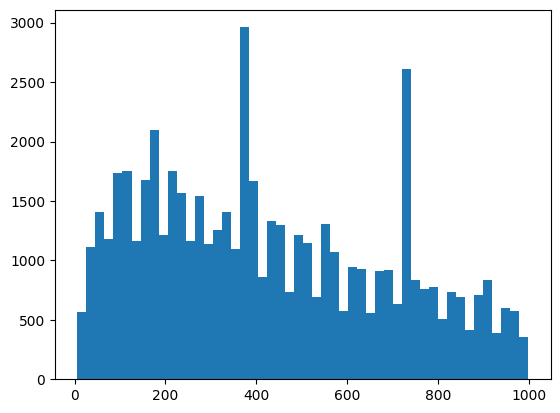

In [30]:
plt.hist(T, bins = 50)
plt.show()

L'estimateur de KaplanMeier est un estimateur non paramétrique de la fonction de survie

A faire: Estimateur Kaplan Meier et premières analyses descriptives !!! 

<Axes: xlabel='timeline'>

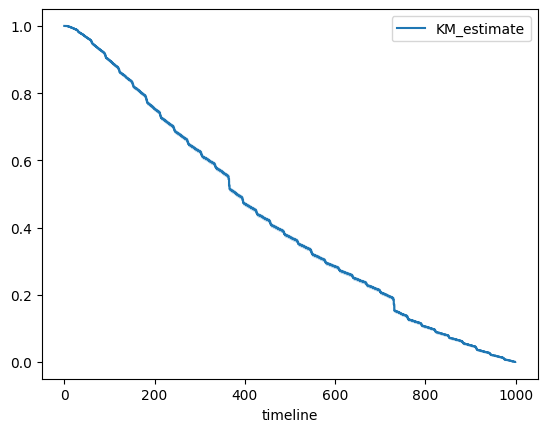

In [31]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T)
kmf.plot_survival_function()

In [43]:
df['event']= True

In [66]:
df['LocationCountry'].value_counts()[:10].index

Index(['United States of America', 'China', 'Turkey', 'Egypt', 'France',
       'United Kingdom', 'Italy', 'Spain', 'Pakistan', 'Canada'],
      dtype='object', name='LocationCountry')

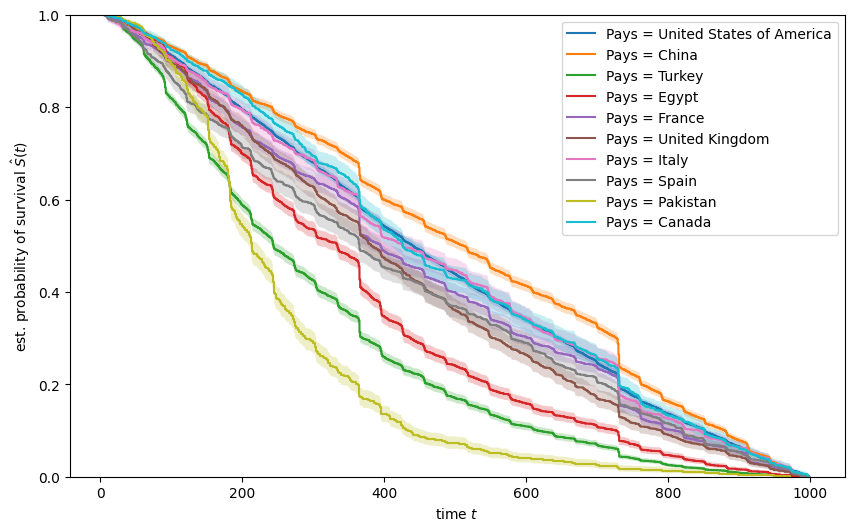

In [123]:
plt.figure(figsize=(10, 6)) 

for Country in df['LocationCountry'].value_counts()[:10].index: # On ne prends que les 5 pays les plus représentés pour éviter de tracer une courbe avec trop peu d'observations
    mask_treat = df["LocationCountry"] == Country
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        df["event"][mask_treat],
        df["TimePassed"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Pays = {Country}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [77]:
df['LeadSponsorClass'].value_counts()

LeadSponsorClass
OTHER        42505
INDUSTRY     10622
OTHER_GOV     1524
NETWORK        224
FED            219
NIH            210
INDIV           19
UNKNOWN         16
Name: count, dtype: int64

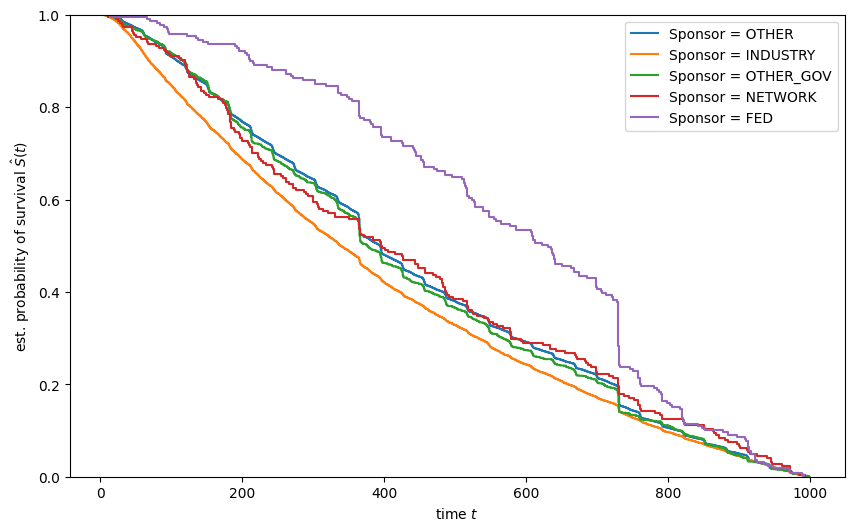

In [122]:
plt.figure(figsize=(10, 6)) 

for Country in df['LeadSponsorClass'].value_counts()[:5].index: 
    mask_treat = df["LeadSponsorClass"] == Country
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df["event"][mask_treat],
        df["TimePassed"][mask_treat],
        conf_type=None,
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Sponsor = {Country}")
    # plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [91]:
df['HealthyVolunteers'].fillna('').value_counts()

HealthyVolunteers
No                            32746
Accepts Healthy Volunteers    20034
                               2559
Name: count, dtype: int64

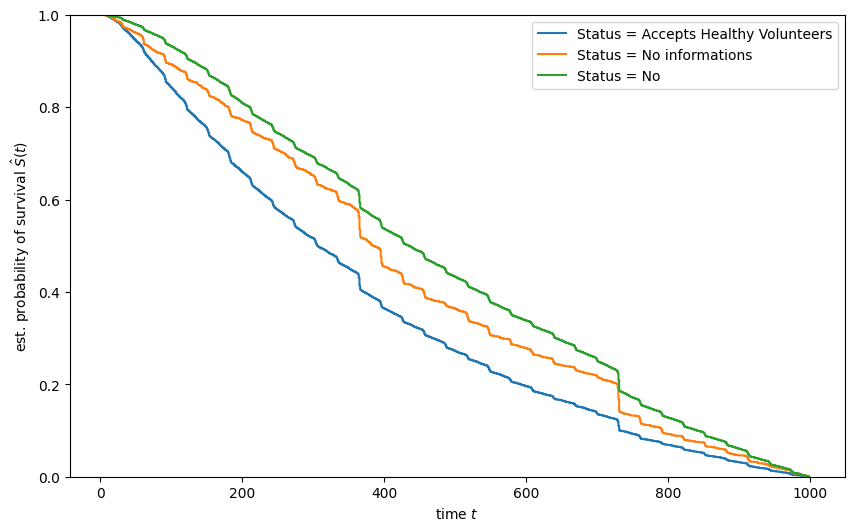

In [93]:
plt.figure(figsize=(10, 6)) 

for Country in df['HealthyVolunteers'].fillna('No informations').unique():
    mask_treat = df["HealthyVolunteers"].fillna('No informations') == Country
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df["event"][mask_treat],
        df["TimePassed"][mask_treat],
        conf_type=None,
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Status = {Country}")
    # plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [120]:
df['CountLines'] = df['EligibilityCriteria'].str.count('\n')//5
df['CountLines'].value_counts()

CountLines
2.0     18430
1.0     11819
3.0     10734
4.0      5031
5.0      2977
6.0      1912
7.0      1183
8.0       810
9.0       543
0.0       421
10.0      409
11.0      276
12.0      194
13.0      149
14.0      113
15.0       89
16.0       56
17.0       39
18.0       36
20.0       27
19.0       26
22.0       14
21.0       12
23.0       10
25.0        6
24.0        5
26.0        4
32.0        4
30.0        3
27.0        2
29.0        2
31.0        1
34.0        1
Name: count, dtype: int64

Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0], dtype='float64', name='CountLines')

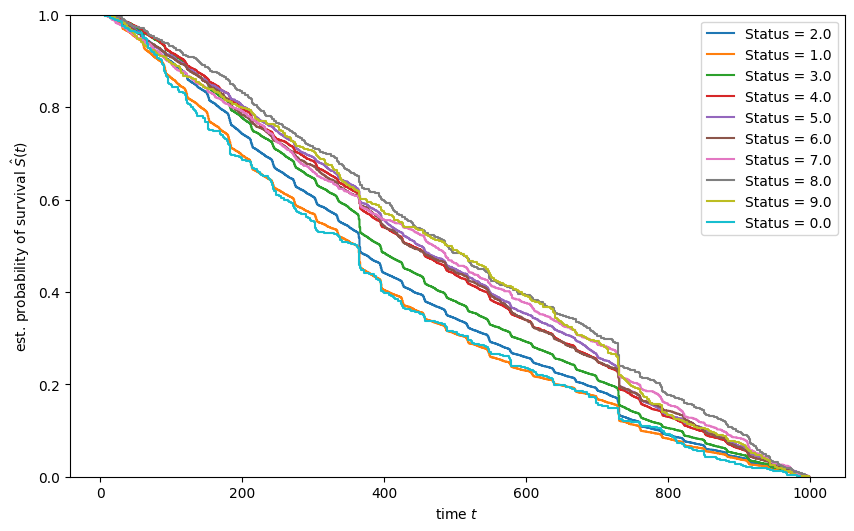

In [124]:
plt.figure(figsize=(10, 6)) 

for Country in df['CountLines'].value_counts().index[:10]:
    mask_treat = df["CountLines"] == Country
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        df["event"][mask_treat],
        df["TimePassed"][mask_treat],
        conf_type=None,
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"Status = {Country}")
    # plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")